# Analyzing Backup Performance

There are several knobs we can turn to tune backup performance, but there isn't a great deal of guidance on what the best settings are for our environment, other than "try them and see!"  A big part of this is that the underlying hardware makes so much of a difference:  being I/O bound on backups means you want to configure things differently from if you are CPU-bound.  Also, if you are backing up a very busy system, you don't want to make the backup so well-tuned that it suddenly takes up 100% of your CPU.  This leads to a series of tradeoffs in configurable settings.

The most important of those settings are:
* Block Size -- The physical block size.  This really only matters for backup tapes and CD-ROMs but it is still settable.  Valid values:  { 0.5kb, 1kb, 2kb, 4kb, 8kb, 16kb, 32kb, 64kb }
* Max Transfer Size -- Maximum amount of data to be transferred per operation.  Valid values:  { 64kb, 128kb, 256kb, 512kb, 1mb, 2mb, 4mb }
* Buffer Count -- Number of buffers of size [MaxTransferSize] to be created.  Valid values:  { 1:N } but I probably wouldn't go above about 1024 without good reason, as with a MaxTransferSize of 4MB, that's up to 4GB of memory used for a single backup.
* File Count -- Tell SQL Server to stripe your backup across multiple files.  This is a nice way of getting extra throughput out of your backups.  Valid values:  { 1:N } but I probably wouldn't go above 10-12 without good reason.
* Compression -- Tell SQL Server whether or not you want to compress your backup.  This has a very minor cost of CPU but typically leads to **much** smaller backups, so my default is to say yes.  Valid values:  { TRUE, FALSE }

Armed with this knowledge, let's say you now want to go tune your systems.  Well, there are a **lot** of combinations.  Let's suppose that we go with the following options:
* Block Size:  { 0.5kb, 1kb, 2kb, 4kb, 8kb, 16kb, 32kb, 64kb }
* Max Transfer Size:  { 64kb, 128kb, 256kb, 512kb, 1mb, 2mb, 4mb }
* Buffer Count:  { 7, 15, 30, 60, 128, 256, 512, 1024 }
* File Count:  { 1, 2, 4, 6, 8, 10, 12 }
* Compression:  { TRUE }

This gives us 3136 separate options.  If your full backup averages 10 minutes, that's an expectation of 224 hours straight of backups to try each of these options.  If you have a terabyte-sized backup which takes 90 minutes to complete, you'll get your answer in approximately 84 days.

But there's a not-so-secret weapon we can use:  sampling.  Without getting into the statistics of the problem, we can decide to take a random sample of the full set of options and perform an analysis on it.  With a reasonable-sized sample, we can get somewhere close to the actual population values in a fraction of the time.

My sample today is from two databases at six sizes.  I have one database called BAC which includes four separate versions:  the full 136 GB, 89.24 GB, 57.89 GB, and 31.73 GB, where the difference comes from dropping the largest tables one at a time.  In addition, I have two versions of the Stack Overflow database:  one from 2010 when it was 10 GB in size, and another from 2013 when it was 50 GB in size.

I built a Powershell script which builds a Cartesian product of my input arrays (that is, the parameters I laid out above) and runs the [dbatools](https://dbatools.io) cmdlet Backup-DbaDatabase.  I'm writing the output results to an output file.  Then, I manually added a header with the variable names to make it easier to import into R.  I'm sampling the Cartesian product, performing only about 3% of the total number of tests.  That's still a lot of tests, but it's a much more tractable problem:  it means taking about 100 database backups rather than 3000.

The Powershell code is available in the `SampleBackupOptions.ps1` script.

First, we will load the `tidyverse` package.  Then, we will load a package called `randomForest`.  This lets us use a random forest model to analyze our data.  We will load the `caret` package to help us partition training from test data.  Finally, the `evtree` pakage will let us build expected value trees using evolutionary learning (genetic algorithms).

In [102]:
if(!require(tidyverse)) {
  install.packages("tidyverse", repos = "http://cran.us.r-project.org")
  library(tidyverse)
}

if(!require(randomForest)) {
  install.packages("randomForest", repos = "http://cran.us.r-project.org")
  library(randomForest)
}

if(!require(caret)) {
  install.packages("caret", repos = "http://cran.us.r-project.org")
  library(randomForest)
}

if(!require(evtree)) {
    install.packages("evtree", repos = "http://cran.us.r-project.org")
    library(evtree)
}

Loading required package: evtree
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'evtree'"Installing package into 'C:/Users/fease/Documents/R/win-library/3.5'
(as 'lib' is unspecified)
also installing the dependencies 'libcoin', 'mvtnorm', 'Formula', 'inum', 'partykit'



package 'libcoin' successfully unpacked and MD5 sums checked
package 'mvtnorm' successfully unpacked and MD5 sums checked
package 'Formula' successfully unpacked and MD5 sums checked
package 'inum' successfully unpacked and MD5 sums checked
package 'partykit' successfully unpacked and MD5 sums checked
package 'evtree' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\fease\AppData\Local\Temp\Rtmpcfnn9V\downloaded_packages


Warning message:
"package 'evtree' was built under R version 3.5.3"Loading required package: partykit
Warning message:
"package 'partykit' was built under R version 3.5.3"Loading required package: grid
Loading required package: libcoin
Warning message:
"package 'libcoin' was built under R version 3.5.3"Loading required package: mvtnorm
Warning message:
"package 'mvtnorm' was built under R version 3.5.3"

I am using data from six databases of different sizes.  Each file has the same set of variables in the same order.

**NOTE** -- If you get an error when trying to load your own files, make sure that the file is in UTF-8 or ASCII format.  Powershell generates UCS-2 LE BOM files by default and R has trouble reading those.

In [125]:
bac_31gb <- readr::read_delim("Data/BAC_31.73GB_PerfTest.csv", delim = ",",
  col_names = c("BlockSize", "BufferCount", "MaxTransferSize", "FileCount", "Duration"),
  col_types = cols(
      BlockSize = col_integer(),
      BufferCount = col_integer(),
      MaxTransferSize = col_integer(),
      FileCount = col_integer(),
      Duration = col_integer()
))

bac_58gb <- readr::read_delim("Data/BAC_57.89GB_PerfTest.csv", delim = ",",
  col_names = c("BlockSize", "BufferCount", "MaxTransferSize", "FileCount", "Duration"),
  col_types = cols(
      BlockSize = col_integer(),
      BufferCount = col_integer(),
      MaxTransferSize = col_integer(),
      FileCount = col_integer(),
      Duration = col_integer()
))

bac_89gb <- readr::read_delim("Data/BAC_89.24GB_PerfTest.csv", delim = ",",
  col_names = c("BlockSize", "BufferCount", "MaxTransferSize", "FileCount", "Duration"),
  col_types = cols(
      BlockSize = col_integer(),
      BufferCount = col_integer(),
      MaxTransferSize = col_integer(),
      FileCount = col_integer(),
      Duration = col_integer()
))

bac_136gb <- readr::read_delim("Data/BAC_136GB_PerfTest.csv", delim = ",",
  col_names = c("BlockSize", "BufferCount", "MaxTransferSize", "FileCount", "Duration"),
  col_types = cols(
      BlockSize = col_integer(),
      BufferCount = col_integer(),
      MaxTransferSize = col_integer(),
      FileCount = col_integer(),
      Duration = col_integer()
))

so_10gb <- readr::read_delim("Data/SO2010_10GB_PerfTest.csv", delim = ",",
  col_names = c("BlockSize", "BufferCount", "MaxTransferSize", "FileCount", "Duration"),
  col_types = cols(
      BlockSize = col_integer(),
      BufferCount = col_integer(),
      MaxTransferSize = col_integer(),
      FileCount = col_integer(),
      Duration = col_integer()
))

so_50gb <- readr::read_delim("Data/SO2013_50GB_PerfTest.csv", delim = ",",
  col_names = c("BlockSize", "BufferCount", "MaxTransferSize", "FileCount", "Duration"),
  col_types = cols(
      BlockSize = col_integer(),
      BufferCount = col_integer(),
      MaxTransferSize = col_integer(),
      FileCount = col_integer(),
      Duration = col_integer()
))


I want to be able to combine the sets of data together and draw conclusions across the broader scope.  In order to differentiate the sets of data, I have added in a new variable, DatabaseSize.

In [126]:
bac_31gb$DatabaseSize <- 31.73
bac_58gb$DatabaseSize <- 57.89
bac_89gb$DatabaseSize <- 89.24
bac_136gb$DatabaseSize <- 136.
so_10gb$DatabaseSize <- 10.
so_50gb$DatabaseSize <- 50.

backupstats <- rbind(bac_31gb, bac_58gb, bac_89gb, bac_136gb, so_10gb, so_50gb)

To help interpret the results a bit easier, I'm converting block size to kilobytes and max transfer size to 64 kilobyte chunks.  Otherwise, in the linear regression below, we'd have to think about the change in a single byte, and that's a bit crazy.  These are linear transformations of independent variables, so this change does not affect the end results aside from scaling the betas.

In [127]:
backupstats$BlockSizeKB <- backupstats$BlockSize / 1024.0
backupstats$MaxTransferSize64KB <- backupstats$MaxTransferSize / (1024.0 * 64)

## Building A Random Forest -- Take 1

I'd first like to try creating a random forest with this input data.  I'm going to create 2000 trees and will include importance information.

In [128]:
model <- randomForest::randomForest(Duration ~ BlockSizeKB + BufferCount + MaxTransferSize64KB + FileCount + DatabaseSize,
               data = backupstats,
               ntree=2000,
               importance=TRUE
           )

Because I included importance information, I can call the `importance` function to see which variables are most effective in describing duration.  By default, this function call returns two variables:  percent increase in mean squared error (`%IncMSE`) and increase in node purity `IncNodePurity`.  The increase in node purity is a biased measure which we should only use if `%IncMSE` is too expensive to calculate ([source](https://stats.stackexchange.com/questions/162465/in-a-random-forest-is-larger-incmse-better-or-worse)), so we will focus on the MSE changes.

In [129]:
randomForest::importance(model, scale=TRUE)

,%IncMSE,IncNodePurity
BlockSizeKB,-0.2804071,173972.8
BufferCount,1.5989731,173266.3
MaxTransferSize64KB,-2.2185144,149357.7
FileCount,-3.6168459,150626.2
DatabaseSize,139.1782437,2761543.9


Most of our variables have a negative percent included in Mean Squared Error value.  This might be a bit weird to think about:  a negative percentage means that the feature is not relevant.  I'm a bit surprised that max transfer size and file count don't have any effect on backup time.

The biggest contender was obviously database size:  larger databases take more time.  After that is buffer count.  But I think that max transfer size and file count really do have an effect; I just think we have a data problem which is preventing us from seeing it.

The last thing I want to look at is the percent of variance explained by the model, which I can see by just calling `model`.

In [130]:
model


Call:
 randomForest(formula = Duration ~ BlockSizeKB + BufferCount +      MaxTransferSize64KB + FileCount + DatabaseSize, data = backupstats,      ntree = 2000, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 2000
No. of variables tried at each split: 1

          Mean of squared residuals: 1085.051
                    % Var explained: 86.06

Our model explains 86% of **training** data set's variance.  That's an okay start.  If I were building a predictive model, I would want a separate test data set and compare my model's predictions against reality. But for this case, I really am more interested in seeing what drives change rather than predicting the ideal parameters, so I'll keep moving.

## Building a Random Forest -- Take 2

Our first approach was a bit naive, in the sense that we looked at each variable independently.  But that's not quite how SQL Server works.  The important thing is not necessarily buffer count or max transfer size, but rather the combination of the two, as they tell us how much memory SQL Server allocates to taking the backup.  For example, 7 buffers and a 128 KB max transfer size means that we will use 7 * 128KB = 896KB of memory for the backup itself.

Let's convert max transfer size and buffer count into total memory usage.  To avoid integer overflow errors, we will convert max transfer size (which we have in bytes) to megabytes before multiplying by buffer count.

In [131]:
backupstats$MemoryUsageMB <- (backupstats$MaxTransferSize / (1024.0 * 1024.0)) * backupstats$BufferCount

In [132]:
model2 <- randomForest::randomForest(Duration ~ BlockSizeKB + MemoryUsageMB + FileCount + DatabaseSize,
               data = backupstats,
               ntree=2000,
               importance=TRUE
           )

We will try the same thing as before, except instead of separate max transfer size and buffer count variables, we will use the combination of the two.

In [133]:
randomForest::importance(model2, scale=TRUE)

,%IncMSE,IncNodePurity
BlockSizeKB,1.8455497,148023.3
MemoryUsageMB,9.1167057,230645.7
FileCount,0.3464133,124435.2
DatabaseSize,177.4819351,3110149.3


Now things get interesting:  notice that signs have flipped:  now everything is positive.  The reason is that buffer count and max transfer size are **parts** of a relevant feature:  memory usage.  Without the appropriate feature and using just its component parts, we had a radically different result.

We can see that the combination of the two features is stronger than either one independently.  Let's see how the model scores overall.

In [134]:
model2


Call:
 randomForest(formula = Duration ~ BlockSizeKB + MemoryUsageMB +      FileCount + DatabaseSize, data = backupstats, ntree = 2000,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 2000
No. of variables tried at each split: 1

          Mean of squared residuals: 634.3813
                    % Var explained: 91.85

We can see that this increases variance explained as well, so we have a stronger model and a better indication of what matters.

But there's another thing we can do to try to make this better.

## Building a Random Forest -- Take 3

So far, the dominating factor in our model is the datbase size, and that makes a lot of sense:  it takes more time to back up a larger database than a smaller one.  What would be great is if we could get an idea of this independent of database size.  To do that, we'll change our dependent variable from number of seconds to gigabytes processed per second.  We might lose the `DatabaseSize` feature in the process, but we'll see if that helps us any.

In [135]:
backupstats$SecPerGB <- backupstats$Duration / backupstats$DatabaseSize

In [136]:
model3 <- randomForest::randomForest(SecPerGB ~ BlockSizeKB + MemoryUsageMB + FileCount + DatabaseSize,
               data = backupstats,
               ntree=2000,
               importance=TRUE
           )

With this new model in place, let's look at the importance measures.

In [137]:
randomForest::importance(model3, scale=TRUE)

,%IncMSE,IncNodePurity
BlockSizeKB,6.83259,3.615819
MemoryUsageMB,72.10212,15.949337
FileCount,21.24623,5.340938
DatabaseSize,78.58584,12.834997


Now we have a couple of interesting findings:  first, block size has become the smallest feature in terms of explanatory value.  That's an indication that block size is **not** important in determining the amount of time needed to process a backup.  Second, memory usage is now just as important than database size, which tells us that having more memory in place does seem to help out on net.  Finally, file count has become somewhat important, though less important than database size in general or memory usage.

In [138]:
model3


Call:
 randomForest(formula = SecPerGB ~ BlockSizeKB + MemoryUsageMB +      FileCount + DatabaseSize, data = backupstats, ntree = 2000,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 2000
No. of variables tried at each split: 1

          Mean of squared residuals: 0.04878339
                    % Var explained: 52.68

Our explained variance has dropped considerably.  It would appear that there are some factors which don't explain very well how quickly we process a database.

## Testing The Boundaries

What I'm going to do next is keep three of my four variables fixed and modify the fourth to get a better understanding of what the overall model thinks.  Remember that our prediction is seconds per GB, so lower numbers are better.  Also, we will keep block size fixed because it appears not to have much impact in this final model.

In [139]:
buffer_test <- data.frame(16, c(7, 1, 2, 4, 16, 32, 128, 512, 1024, 2048, 4095, 4096, 20480, 409600, 81920000), 4, 17)
names(buffer_test) <- c("BlockSizeKB", "MemoryUsageMB", "FileCount", "DatabaseSize")
buffer_test$prediction <- predict(model3, buffer_test)
buffer_test$seconds <- buffer_test$DatabaseSize * buffer_test$prediction
buffer_test

BlockSizeKB,MemoryUsageMB,FileCount,DatabaseSize,prediction,seconds
16,7,4,17,2.049607,34.84332
16,1,4,17,2.112088,35.90549
16,2,4,17,2.086688,35.47369
16,4,4,17,2.085076,35.44629
16,16,4,17,2.024009,34.40815
16,32,4,17,1.983371,33.71731
16,128,4,17,1.816141,30.87440
16,512,4,17,1.790372,30.43632
16,1024,4,17,1.773635,30.15180
16,2048,4,17,1.754126,29.82014


SQL Server's default for backups is often 7 buffers and 1MB max transfer size, for a total of 7MB memory usage.  At that level, a backup of 17GB is expected to take about 34 seconds given this model.

If we bump the buffers up, we max out somewhere between 2GB and 4GB.  The largest values we have are 4GB, so we should not trust a random forest regression above that level.

If we look at similar comps, we don't have anything precisely matching, but there are a couple with 128MB memory usage and 1.73-1.79 seconds per GB, which is close to the 1.81 we predicted.

In [141]:
backupstats %>% filter(FileCount == 4 & BlockSizeKB == 16) %>% arrange(MemoryUsageMB)

BlockSize,BufferCount,MaxTransferSize,FileCount,Duration,DatabaseSize,BlockSizeKB,MaxTransferSize64KB,MemoryUsageMB,SecPerGB
16384,30,131072,4,211,89.24,16,2,3.75,2.364411
16384,7,1048576,4,125,57.89,16,16,7.00,2.159268
16384,15,524288,4,303,136.00,16,8,7.50,2.227941
16384,7,4194304,4,134,50.00,16,64,28.00,2.680000
16384,30,1048576,4,298,136.00,16,16,30.00,2.191176
16384,30,2097152,4,120,50.00,16,32,60.00,2.400000
16384,128,1048576,4,55,31.73,16,16,128.00,1.733375
16384,256,524288,4,57,31.73,16,8,128.00,1.796407
16384,1024,262144,4,51,31.73,16,4,256.00,1.607312
16384,512,4194304,4,280,136.00,16,64,2048.00,2.058824


We can also see that as database size goes up a bit, seconds per GB increases as well, though database size is obviously not the only determining factor.

In [143]:
backupstats %>% filter(FileCount == 4 & BlockSizeKB == 16) %>% arrange(DatabaseSize)

BlockSize,BufferCount,MaxTransferSize,FileCount,Duration,DatabaseSize,BlockSizeKB,MaxTransferSize64KB,MemoryUsageMB,SecPerGB
16384,1024,262144,4,51,31.73,16,4,256.00,1.607312
16384,128,1048576,4,55,31.73,16,16,128.00,1.733375
16384,256,524288,4,57,31.73,16,8,128.00,1.796407
16384,1024,2097152,4,96,50.00,16,32,2048.00,1.920000
16384,30,2097152,4,120,50.00,16,32,60.00,2.400000
16384,7,4194304,4,134,50.00,16,64,28.00,2.680000
16384,7,1048576,4,125,57.89,16,16,7.00,2.159268
16384,30,131072,4,211,89.24,16,2,3.75,2.364411
16384,512,4194304,4,280,136.00,16,64,2048.00,2.058824
16384,30,1048576,4,298,136.00,16,16,30.00,2.191176


Let's move on to look at file counts.  I'm going to try 1-15 files even though we only tested 1, 2, 4, 6, 8, 10, and 12 files.

In [144]:
file_test <- data.frame(16, 1024, 1:15, 57.89)
names(file_test) <- c("BlockSizeKB", "MemoryUsageMB", "FileCount", "DatabaseSize")
file_test$prediction <- predict(model3, file_test)
file_test$seconds <- file_test$DatabaseSize * file_test$prediction
file_test

BlockSizeKB,MemoryUsageMB,FileCount,DatabaseSize,prediction,seconds
16,1024,1,57.89,2.069955,119.8297
16,1024,2,57.89,2.028695,117.4412
16,1024,3,57.89,2.028371,117.4224
16,1024,4,57.89,2.010996,116.4166
16,1024,5,57.89,2.010716,116.4004
16,1024,6,57.89,2.003506,115.9830
16,1024,7,57.89,2.003371,115.9752
16,1024,8,57.89,1.989981,115.2000
16,1024,9,57.89,1.990623,115.2372
16,1024,10,57.89,1.966556,113.8439


Notice that we have unique values through 12.  The random forest algorithm does **not** extrapolate beyond the test range, meaning that anything above 12 files will be treated as 12 files.

We didn't have any exact matches on block size, but that didn't look to be very important.  Looking at our predictions, the 4-file count was a little slow compared to reality.  We had some variance in 8-file counts, and our prediction was pretty good.  Finally, our 10-file prediction was also fine.  That's a decent sign, though we should temper our expectations because we trained against this data.

In [145]:
backupstats %>% filter(MemoryUsageMB == 1024 & DatabaseSize == 57.89) %>% arrange(FileCount)

BlockSize,BufferCount,MaxTransferSize,FileCount,Duration,DatabaseSize,BlockSizeKB,MaxTransferSize64KB,MemoryUsageMB,SecPerGB
65536,512,2097152,4,114,57.89,64.0,32,1024,1.969252
512,256,4194304,8,119,57.89,0.5,64,1024,2.055623
2048,1024,1048576,8,114,57.89,2.0,16,1024,1.969252
2048,256,4194304,10,115,57.89,2.0,64,1024,1.986526


Finally, let's look at database sizes.

In [146]:
# Random forest does *not* do a regression here.
size_test <- data.frame(16, 1024, 4, 10:200)
names(size_test) <- c("BlockSizeKB", "MemoryUsageMB", "FileCount", "DatabaseSize")
size_test$prediction <- predict(model3, size_test)
size_test$seconds <- size_test$DatabaseSize * size_test$prediction
size_test

BlockSizeKB,MemoryUsageMB,FileCount,DatabaseSize,prediction,seconds
16,1024,4,10,1.773635,17.73635
16,1024,4,11,1.773635,19.50999
16,1024,4,12,1.773635,21.28362
16,1024,4,13,1.773635,23.05726
16,1024,4,14,1.773635,24.83090
16,1024,4,15,1.773635,26.60453
16,1024,4,16,1.773635,28.37817
16,1024,4,17,1.773635,30.15180
16,1024,4,18,1.773635,31.92544
16,1024,4,19,1.773635,33.69907


The predictions look weird.

In [147]:
size_test %>% group_by(prediction) %>% summarize(n = n())

prediction,n
1.761780,10
1.762568,3
1.762796,7
1.773635,11
2.010996,16
2.011334,4
2.028559,20
2.029941,3
2.032375,16
2.045953,4


It looks like we get only a few total predictions for seconds per GB, and let's look at where those are:

In [148]:
size_test %>% group_by(prediction) %>% summarize(min = min(DatabaseSize), max = max(DatabaseSize))

prediction,min,max
1.761780,21,30
1.762568,31,33
1.762796,34,40
1.773635,10,20
2.010996,54,69
2.011334,70,73
2.028559,74,93
2.029941,94,96
2.032375,97,112
2.045953,41,44


It looks like these are cutoffs somewhere around our database sizes, though not exactly:  there are only six files, but more than six ranges.  Given that the numbers are increasing, it indicates that our larger databases in this test were harder to back up than the smaller ones.  We might normally expect this number to remain constant (if there's no difference in processing capabilities) or maybe to go **down** (because we can amortize spinup and spindown costs over larger data sets), but going **up** is mildy weird.

## Contrast With A Linear Model

In [149]:
linear_model <- lm(data = backupstats, SecPerGB ~ BlockSizeKB + MemoryUsageMB + FileCount + DatabaseSize)
summary(linear_model)


Call:
lm(formula = SecPerGB ~ BlockSizeKB + MemoryUsageMB + FileCount + 
    DatabaseSize, data = backupstats)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51617 -0.15745 -0.04970  0.07968  2.60384 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.193e+00  3.378e-02  64.923  < 2e-16 ***
BlockSizeKB    2.555e-04  6.056e-04   0.422    0.673    
MemoryUsageMB -1.614e-04  1.823e-05  -8.855  < 2e-16 ***
FileCount     -1.933e-02  3.225e-03  -5.993 3.79e-09 ***
DatabaseSize   1.414e-03  3.109e-04   4.548 6.70e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2901 on 536 degrees of freedom
Multiple R-squared:  0.1912,	Adjusted R-squared:  0.1852 
F-statistic: 31.68 on 4 and 536 DF,  p-value: < 2.2e-16


This linear model has an adjusted R^2 of 0.1852, which is terrible.  The only thing this has going for it is that the signs appear correct:  as memory usage and file count go up, the number of seconds it takes to process a GB worth of data decreases.  We can try a second linear model which goes back to duration and see if that's any better.

In [150]:
linear_model <- lm(data = backupstats, Duration ~ BlockSizeKB + MemoryUsageMB + FileCount + DatabaseSize)
summary(linear_model)


Call:
lm(formula = Duration ~ BlockSizeKB + MemoryUsageMB + FileCount + 
    DatabaseSize, data = backupstats)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.540  -7.797  -2.794   5.204  80.514 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    7.4034305  1.4055160   5.267 2.01e-07 ***
BlockSizeKB    0.0148892  0.0251982   0.591    0.555    
MemoryUsageMB -0.0080964  0.0007586 -10.672  < 2e-16 ***
FileCount     -0.9685435  0.1341842  -7.218 1.81e-12 ***
DatabaseSize   2.1697292  0.0129374 167.710  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.07 on 536 degrees of freedom
Multiple R-squared:  0.9815,	Adjusted R-squared:  0.9813 
F-statistic:  7091 on 4 and 536 DF,  p-value: < 2.2e-16


Now it's saying that duration is primarily a function of database size:  every GB of data takes approximately 2.16 seconds longer to process.  Memory usage and file count are still pointing in the right direction:  one MB of memory usage leads to 0.008 seconds **less** processing time and each file is responsible for approximately 1 less second.

Let's try to predict some results with this model.

In [155]:
size_test %>% filter(DatabaseSize %in% c(50, 58, 89, 136)) %>% predict(linear_model, .)

1        2        3        4 
103.9632 121.3210 188.5826 290.5599

Here are our actual results.

In [156]:
filter(backupstats, MemoryUsageMB == 1024 & FileCount == 4) %>% arrange(DatabaseSize)

BlockSize,BufferCount,MaxTransferSize,FileCount,Duration,DatabaseSize,BlockSizeKB,MaxTransferSize64KB,MemoryUsageMB,SecPerGB
8192,512,2097152,4,97,50.00,8,32,1024,1.940000
65536,512,2097152,4,114,57.89,64,32,1024,1.969252
2048,512,2097152,4,178,89.24,2,32,1024,1.994621
8192,256,4194304,4,283,136.00,8,64,1024,2.080882


There are four close-enough matches, and we tend to be about 10 seconds off.  This is an alright start and indicates that we might be able to treat this as a linear-ish problem.

## Proper Training and Testing of a Model

So far, we have dumped all of the data into our algorithm and generated models.  This is okay for basic exploration, but it is liable to overfit without us knowing.  Instead, we are going to use the `caret` package to split out our data into separate training and test data sets.

In [157]:
set.seed(20191119)
randbackupstats <- backupstats[sample(nrow(backupstats)), ]
randbackupstats$BlockSize <- NULL
randbackupstats$BufferCount <- NULL
randbackupstats$MaxTransferSize <- NULL
randbackupstats$Duration <- NULL
randbackupstats$GBperSec <- NULL
trainIndex <- caret::createDataPartition(randbackupstats$SecPerGB, p = 0.7, list = FALSE, times = 1)
train_data <- randbackupstats[trainIndex,]
test_data <- randbackupstats[-trainIndex,]
nrow(train_data)
nrow(test_data)

[1] 381

[1] 160

Let's take a quick look at our training data to make sure that everything turned out alright.

In [158]:
head(train_data)

FileCount,DatabaseSize,BlockSizeKB,MaxTransferSize64KB,MemoryUsageMB,SecPerGB
4,57.89,4,64,2048.000,1.986526
1,57.89,8,1,64.000,2.072897
6,57.89,64,4,256.000,1.969252
10,31.73,1,8,128.000,1.638828
1,57.89,32,1,16.000,2.176542
8,57.89,8,2,0.875,2.193816


Here is our new model, built solely against training data.

In [160]:
modelT <- randomForest::randomForest(SecPerGB ~ BlockSizeKB + MemoryUsageMB + FileCount + DatabaseSize,
               data = train_data,
               ntree=2000,
               importance=TRUE
           )

We can review the model results.  Our explained variance dropped a good bit versus the random forest with all data.

In [161]:
modelT


Call:
 randomForest(formula = SecPerGB ~ BlockSizeKB + MemoryUsageMB +      FileCount + DatabaseSize, data = train_data, ntree = 2000,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 2000
No. of variables tried at each split: 1

          Mean of squared residuals: 0.06500353
                    % Var explained: 41.54

I can then generate predictions against our test data using the trained model.

In [162]:
modelTPred <- predict(modelT, test_data)

The `modelTPred` result needs to be converted to a data frame; after that, we can column bind it to our `test_data` data set to show predictions along with input data.

In [163]:
outcomes <- cbind(test_data, as.data.frame(modelTPred))

Now let's look at the outcomes.

In [164]:
head(outcomes)

FileCount,DatabaseSize,BlockSizeKB,MaxTransferSize64KB,MemoryUsageMB,SecPerGB,modelTPred
2,89.24,4.0,64,2048.00,1.983416,2.038565
4,31.73,0.5,32,30.00,1.953987,2.198787
2,136.00,1.0,32,512.00,2.102941,2.105967
1,136.00,32.0,32,120.00,2.169118,2.144195
2,57.89,8.0,8,128.00,2.090171,2.068387
8,57.89,8.0,2,3.75,2.159268,2.176389


These predictions aren't incredible, though we can see some hits in here.

## EV Trees and Genetic Algorithms -- Take 1

Another approach we can take is to use genetic algorithms.  This talk won't get into genetic algorithms directly, though if you are interested, you can review [my talk on the topic](https://csmore.info/on/genetics) and [my blog series on the topic](https://36chambers.wordpress.com/genetics-in-action/).

We will build an evolutionary tree which matches the regression tree from earlier.  Just like our prior demo, we will use the training data and compare against test data.

In [165]:
ev <- evtree(SecPerGB ~ BlockSizeKB + MemoryUsageMB + FileCount + DatabaseSize,
             data = train_data, minbucket = 10, maxdepth = 4)

We can get a visual interpretation of our model using the `plot()` function.

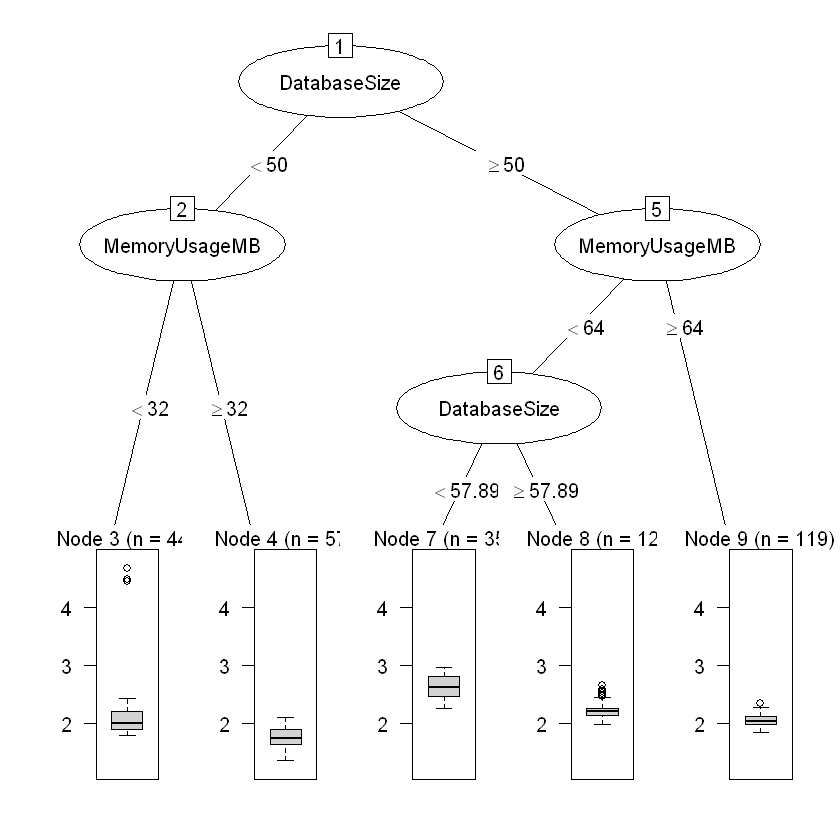

In [166]:
plot(ev)

Because the visual interpretation can be a bit tricky, we can also get a treeview version, including some error information.

In [167]:
ev


Model formula:
SecPerGB ~ BlockSizeKB + MemoryUsageMB + FileCount + DatabaseSize

Fitted party:
[1] root
|   [2] DatabaseSize < 50
|   |   [3] MemoryUsageMB < 32: 2.189 (n = 44, err = 19.0)
|   |   [4] MemoryUsageMB >= 32: 1.764 (n = 57, err = 1.4)
|   [5] DatabaseSize >= 50
|   |   [6] MemoryUsageMB < 64
|   |   |   [7] DatabaseSize < 57.89: 2.610 (n = 35, err = 1.3)
|   |   |   [8] DatabaseSize >= 57.89: 2.219 (n = 126, err = 1.9)
|   |   [9] MemoryUsageMB >= 64: 2.048 (n = 119, err = 1.0)

Number of inner nodes:    4
Number of terminal nodes: 5

Let's now build out our predictions and append them to test_data.

In [168]:
test_data$PredSecPerGB <- predict(ev, test_data)

In [169]:
head(test_data)

FileCount,DatabaseSize,BlockSizeKB,MaxTransferSize64KB,MemoryUsageMB,SecPerGB,PredSecPerGB
2,89.24,4.0,64,2048.00,1.983416,2.047712
4,31.73,0.5,32,30.00,1.953987,2.188674
2,136.00,1.0,32,512.00,2.102941,2.047712
1,136.00,32.0,32,120.00,2.169118,2.047712
2,57.89,8.0,8,128.00,2.090171,2.047712
8,57.89,8.0,2,3.75,2.159268,2.219270


Not as many obvious hits here, though it does seem like we're missing in both directions so it doesn't appear too biased.  Of course, drawing these sorts of conclusions from the first six results is a terrible idea.

Let's look at the Root Mean Squared Error.  This gives us a measure of how far off we are in the unit of our dependent variable.

In [170]:
sqrt(mean((test_data$SecPerGB - test_data$PredSecPerGB)^2))

[1] 0.1546588

This means we are, on average 0.15 seconds per GB off.  For a 136 GB file, that's a difference of 20.4 seconds.  By contrast, here is the range of values for that file:

In [171]:
summary(bac_136gb$Duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  267.0   287.5   292.0   292.7   301.0   308.0 

Given that we have a 31-second split, being off by 20.4 isn't a great result.  This particular EV tree doesn't look like it helps us much.  So let's try a different version.

## EV Trees and Genetic Algorithms -- Take 2

Although we won't use proper training and testing, we can compare this model to the random forest above.

In [172]:
ev2 <- evtree(Duration ~ BlockSizeKB + MemoryUsageMB + FileCount + DatabaseSize,
               data = backupstats,
               minbucket = 10,
               maxdepth = 4
           )

Here's what the plot looks like.

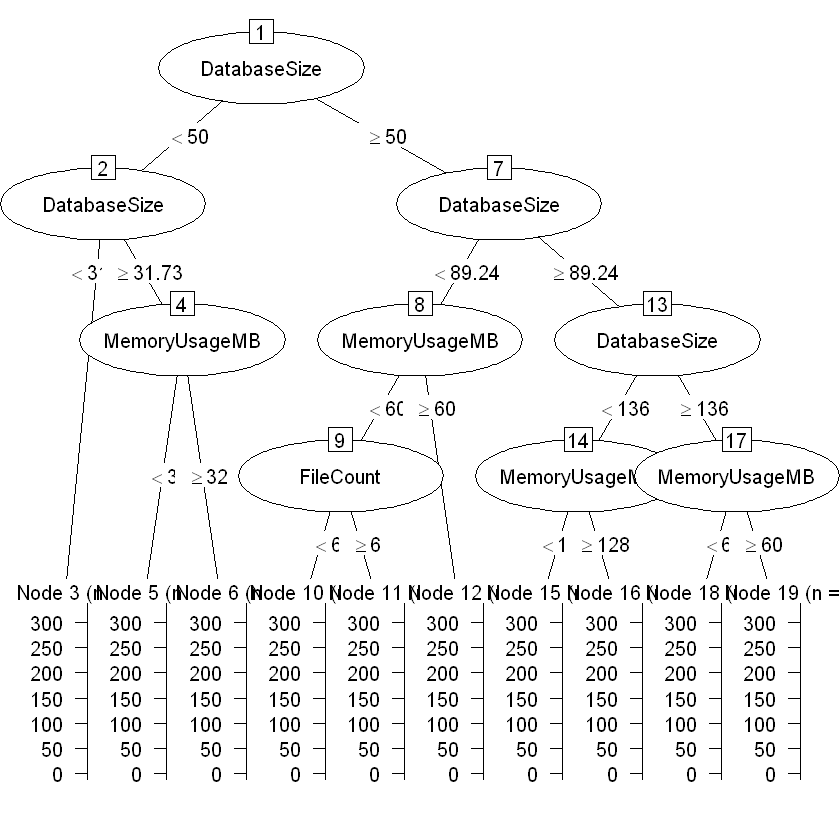

In [173]:
plot(ev2)

Our model got a lot more complicated, so now the treeview becomes important.

In [174]:
ev2


Model formula:
Duration ~ BlockSizeKB + MemoryUsageMB + FileCount + DatabaseSize

Fitted party:
[1] root
|   [2] DatabaseSize < 50
|   |   [3] DatabaseSize < 31.73: 18.893 (n = 56, err = 279.4)
|   |   [4] DatabaseSize >= 31.73
|   |   |   [5] MemoryUsageMB < 32: 69.163 (n = 43, err = 19251.9)
|   |   |   [6] MemoryUsageMB >= 32: 55.115 (n = 52, err = 1569.3)
|   [7] DatabaseSize >= 50
|   |   [8] DatabaseSize < 89.24
|   |   |   [9] MemoryUsageMB < 60
|   |   |   |   [10] FileCount < 6: 136.395 (n = 43, err = 3262.3)
|   |   |   |   [11] FileCount >= 6: 124.613 (n = 62, err = 2714.7)
|   |   |   [12] MemoryUsageMB >= 60: 111.229 (n = 83, err = 5062.7)
|   |   [13] DatabaseSize >= 89.24
|   |   |   [14] DatabaseSize < 136
|   |   |   |   [15] MemoryUsageMB < 128: 200.619 (n = 63, err = 4422.9)
|   |   |   |   [16] MemoryUsageMB >= 128: 179.028 (n = 36, err = 407.0)
|   |   |   [17] DatabaseSize >= 136
|   |   |   |   [18] MemoryUsageMB < 60: 300.956 (n = 45, err = 947.9)
|   |   |   |

Here is our new Root Mean Squared Error, this time in seconds rather than seconds per gigabyte.

In [175]:
sqrt(mean((backupstats$Duration - predict(ev2))^2))

[1] 8.651715

This says that, for our training data set, we tend to be about 8.7 seconds off.  Here is the range of values:

In [176]:
summary(backupstats$Duration)

backupstats %>%
    group_by(DatabaseSize) %>%
    summarize (min = min(Duration), max = max(Duration), n = n(), mean = mean(Duration))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   16.0    66.0   125.0   145.9   201.0   308.0 

DatabaseSize,min,max,n,mean
10.00,16,24,56,18.89286
31.73,39,148,95,61.47368
50.00,92,148,90,120.66667
57.89,114,154,98,122.07143
89.24,175,218,99,192.76768
136.00,267,308,103,292.67961


## Conclusion

There are a few interesting takeaways here.

* If you are looking at estimating backup duration, database size will dominate.
* Converting our measure to instead minimize processing time (seconds per gigabyte of data), database size no longer dominates, though it is interesting that it still remains pertinent.
* Block size is not particularly helpful in any of these models.
* The linear model does a mediocre job of estimating backup performance, telling us that our problem is not linear in nature but we can kind of estimate it as linear with enough data.